## Imports

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


## Data load

In [2]:
df = pd.read_csv("data.csv")

In [4]:
df = df[df["JAHR"] <= 2020]

In [5]:
df

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
50,Alkoholunfälle,insgesamt,2020,Summe,430.0,434.0,NaN,-0.92,NaN
51,Alkoholunfälle,insgesamt,2020,202001,28.0,22.0,-20.00,27.27,37.0
52,Alkoholunfälle,insgesamt,2020,202002,40.0,28.0,42.86,42.86,38.0
53,Alkoholunfälle,insgesamt,2020,202003,27.0,34.0,-32.50,-20.59,37.0
54,Alkoholunfälle,insgesamt,2020,202004,26.0,36.0,-3.70,-27.78,36.0
...,...,...,...,...,...,...,...,...,...
2249,Verkehrsunfälle,Verletzte und Getötete,2000,200008,647.0,NaN,-13.04,NaN,584.0
2250,Verkehrsunfälle,Verletzte und Getötete,2000,200009,675.0,NaN,4.33,NaN,594.0
2251,Verkehrsunfälle,Verletzte und Getötete,2000,200010,615.0,NaN,-8.89,NaN,596.0
2252,Verkehrsunfälle,Verletzte und Getötete,2000,200011,578.0,NaN,-6.02,NaN,594.0


## Analysis

In [9]:
df["AUSPRAEGUNG"].unique()

array(['insgesamt', 'Verletzte und Getötete', 'mit Personenschäden'],
      dtype=object)

In [10]:
df["MONATSZAHL"].unique()

array(['Alkoholunfälle', 'Fluchtunfälle', 'Verkehrsunfälle'], dtype=object)

In [26]:
df_cat = df[(df["AUSPRAEGUNG"] == "insgesamt") & (df["MONAT"] == "Summe")]

In [61]:
df_cat

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
50,Alkoholunfälle,insgesamt,2020,Summe,430.0,434.0,NaN,-0.92,NaN
63,Alkoholunfälle,insgesamt,2019,Summe,434.0,398.0,NaN,9.05,NaN
76,Alkoholunfälle,insgesamt,2018,Summe,398.0,409.0,NaN,-2.69,NaN
89,Alkoholunfälle,insgesamt,2017,Summe,409.0,301.0,NaN,35.88,NaN
102,Alkoholunfälle,insgesamt,2016,Summe,301.0,411.0,NaN,-26.76,NaN
115,Alkoholunfälle,insgesamt,2015,Summe,411.0,382.0,NaN,7.59,NaN
128,Alkoholunfälle,insgesamt,2014,Summe,382.0,377.0,NaN,1.33,NaN
141,Alkoholunfälle,insgesamt,2013,Summe,377.0,440.0,NaN,-14.32,NaN
154,Alkoholunfälle,insgesamt,2012,Summe,440.0,397.0,NaN,10.83,NaN
167,Alkoholunfälle,insgesamt,2011,Summe,397.0,402.0,NaN,-1.24,NaN


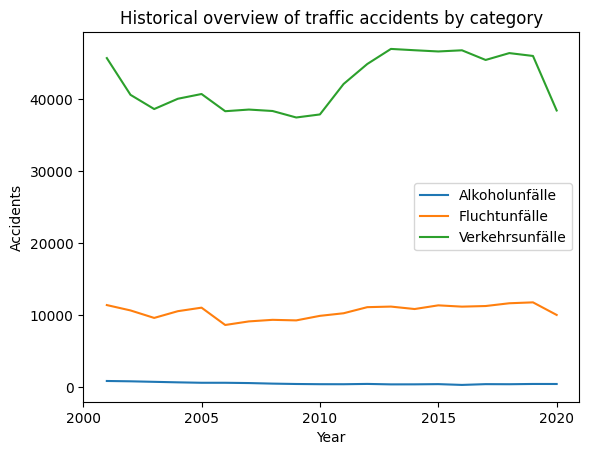

In [60]:
for cat in df["MONATSZAHL"].unique():
    df_tmp = df_cat[df_cat["MONATSZAHL"] == cat]
    plt.plot(df_tmp["JAHR"], df_tmp["WERT"], label=cat)


plt.xlabel("Year")
plt.ylabel("Accidents")
plt.xticks([2000, 2005, 2010, 2015, 2020])
plt.title("Historical overview of traffic accidents by category")
plt.legend()

plt.show()